In [1]:
from neo4j import GraphDatabase
import pandas as pd
from openai import OpenAI
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import mysql.connector
import json
from collections import Counter
import os
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from dowhy import CausalModel
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from dotenv import load_dotenv
import warnings
from typing import Optional, List, Tuple
import numpy as np
from dataclasses import dataclass

load_dotenv()

# NumPy関連のRuntimeWarningを無効化
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

## similarityのスコア化検証

In [ ]:
@dataclass
class FoodResult:
    node_id: str
    node_name: str
    flavor_vector: Optional[List[float]]  # List of floats, or None
    word_vector: Optional[List[float]]    # List of floats, or None
    score: float

In [3]:
def find_food(tx, search_term):
    find_food_query = """
    CALL db.index.fulltext.queryNodes("food_origin_index_text_search", $search_term)
    YIELD node, score
    ORDER BY score DESC, size(node.name)
    LIMIT 1
    RETURN node.id as node_id, node.name as node_name, node.flavor_vector as flavor_vector, node.word_vector as word_vector, score    
    """
    result = tx.run(find_food_query, search_term=search_term).data()
    if result:
        return result[0]
        
    return None

def find_aroma_count(session, id1, id2):
    find_food_sub_type_query = """
    MATCH (f:Food {id: $id})-[s:HAS_SUBTYPE]->(fs:FoodSubType) RETURN fs.id as fs_id
    """
    fs_id1 = session.run(find_food_sub_type_query, id=id1).data()[0]["fs_id"]
    fs_id2 = session.run(find_food_sub_type_query, id=id2).data()[0]["fs_id"]
    find_aroma_query = """
    MATCH (f1:FoodSubType {id: $id1})-[:CONTAINS]->(c:Compound)<-[:CONTAINS]-(f2:FoodSubType {id: $id2})
    RETURN f1.id AS FoodSubType1, f2.id AS FoodSubType2, count(c) AS c
    """
    aroma_result = session.run(find_aroma_query, id1=fs_id1, id2=fs_id2).data()
    return aroma_result[0]["c"] if aroma_result else 0

def get_vector(pd_result, ing1, ing2, key):
    try:
        v1 = pd_result[ing1][key]
        v2 = pd_result[ing2][key]
        return [np.array(v1).reshape(1, -1), np.array(v2).reshape(1, -1)]
    except:
        #print(pd_result)
        return [None, None]

In [4]:
def get_similarities(dish):
    with driver.session() as session:
        ar_result = []
        for target in dish:
            target = target.lower()
            result1 = session.execute_read(find_food, target)
            if result1 is None:
                print(f"No record found: {target}")
                continue
            if result1['flavor_vector'] is None:
                print(f"No flavor vector: {target}")
                continue
            
            ar_result.append(result1)
        
        pd_result = pd.DataFrame(ar_result)
        pd_result = pd_result.transpose()
        
        # 材料のペアを生成
        pairs = list(combinations(list(pd_result.keys()), 2))
        if pairs == []:
            return None, None, None, None
        
        # 類似度を計算
        fv_cosine_similarities = []
        wv_cosine_similarities = []
        food_counts = []
        for ing1, ing2 in pairs:                        
            fv1, fv2 = get_vector(pd_result, ing1, ing2, key='flavor_vector')
            wv1, wv2 = get_vector(pd_result, ing1, ing2, key='word_vector')
            
            if fv1 is None or fv2 is None or wv1 is None or wv2 is None:
                print(f"Empty vector: {ing1}, {ing2}")
                print(pd_result)
                print("------")
                continue
        
            # コサイン類似度
            fv_cosine_sim = cosine_similarity(fv1, fv2)[0, 0]
            wv_cosine_sim = cosine_similarity(wv1, wv2)[0, 0]
            fv_cosine_similarities.append(fv_cosine_sim)
            wv_cosine_similarities.append(wv_cosine_sim)
            
            name1 = pd_result[ing1]['node_id']
            name2 = pd_result[ing2]['node_id']
            food_counts.append(find_aroma_count(session, name1, name2))


        # 各類似度の平均を計算
        fv_cosine_similarity_score = np.mean(fv_cosine_similarities)
        wv_cosine_similarities_score = np.mean(wv_cosine_similarities)
        food_count_score = np.mean(food_counts)
        # 結果を表示
        #print(f"Flavor Cosine Pairwise Similarities: {dict(zip(pairs, fv_cosine_similarities))}")
        #print(f"Word Cosine Pairwise Similarities: {dict(zip(pairs, wv_cosine_similarities))}")
        #print(f"Flavor Cosine Similarity Score: {fv_cosine_similarity_score}")
        #print(f"Word Cosine Similarity Score: {wv_cosine_similarities_score}")
        #print("-------------")
        return dict(zip(pairs, fv_cosine_similarities)), dict(zip(pairs, wv_cosine_similarities)), fv_cosine_similarity_score, wv_cosine_similarities_score, dict(zip(pairs, food_counts)),food_count_score

In [5]:
df_columns = ["name", "rating", "reviews", "total_time", "ingredients", "WD_similar", "FV_similar", "WD_similar_AVG", "FV_similar_AVG"]
df_result = pd.DataFrame(columns=df_columns)
excludes = ["potassium chloride", "grit", "ring", "spoon", "knife", "thermometer", "carb", "shirataki", "soil",
            "potassium", "chloride", "grit", "frying", "coloring", "dan", "lipase", "boil", "casserole", "culture",
            "carbs", "bear", "smoke", "psyllium husk", "starter", "rennet", "bed", "fire", "chutney", "authentic pad thai",
            "punch", "trader joe's", "cornstarch", "spray", "oven", "thai", "creme brulee", "pesto", "tablet", "bacteria", 
            "collagen", "soufflé", "sponge", "hay", "smoke flavoring", "boston", "strainer", "sieve", "panettone mold", "toothpicks"]

In [6]:
new_json_data = {}
with open("../data/formatted_json_recipe.json", "r") as file:
    new_json_data = json.load(file)
print(len(new_json_data))

1327


In [7]:
new_rows = []
for key, row in new_json_data.items():
    if row["ingredients"] == []:
        continue
    
    row["ingredients"] = [ingredient for ingredient in row["ingredients"] if ingredient.strip().lower() not in excludes]

    if len(row["ingredients"]) < 3:
        continue
    
    try:
        wv_vec, fv_vec, wv_vec_avg, fv_vec_avg, mol_count, mol_avg = get_similarities(row["ingredients"])
                    
        if wv_vec is None or fv_vec is None:
            continue
        
        row["WD_similar"] = wv_vec or {}
        row["FV_similar"] = fv_vec or {}
        row["WD_similar_AVG"] = wv_vec_avg or 0
        row["FV_similar_AVG"] = fv_vec_avg or 0
        row["molecules"] = mol_count or {}
        row["molecule_avg"] = mol_avg or 0
        row["count"] = len(row["ingredients"])
    except Exception as e:
        print(e)
        print(row["ingredients"])
        continue
    
    if any(row.values()):
        new_rows.append(row)

In [ ]:
df_result = pd.concat([df_result, pd.DataFrame(new_rows)], ignore_index=True)
print(len(df_result))
df_result.tail(1)

1263


/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_77549/3585736547.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(new_rows)], ignore_index=True)


,name,rating,reviews,total_time,ingredients,WD_similar,FV_similar,WD_similar_AVG,FV_similar_AVG,instructions,molecules,molecule_avg,count
1262,Vasilopita - Greek New Years Cake,,0,60,"[baking powder, butter, egg, sugar, flour, alm...","{(0, 1): 0.6661024985311961, (0, 2): 0.2609892...","{(0, 1): -0.11645454707166915, (0, 2): 0.92183...",0.165442,0.301688,[Preheat the oven to 350 degrees F (175 degree...,"{(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (...",0.027778,9.0


## 

In [ ]:
# 相関分析
for column in ["rating", "reviews", "total_time", "WD_similar_AVG", "FV_similar_AVG"]:
    # 数値変換（できない値は NaN）
    df_result[column] = pd.to_numeric(df_result[column], errors='coerce')
    # 欠損値を 0 で埋める
    df_result[column] = df_result[column].fillna(0)

# 相関行列を計算
correlation_matrix = df_result[["WD_similar_AVG", "FV_similar_AVG", "molecule_avg", "count"]].corr()
correlation_matrix

,WD_similar_AVG,FV_similar_AVG,molecule_avg,count
WD_similar_AVG,1.000000,0.045885,0.046443,0.159951
FV_similar_AVG,0.045885,1.000000,0.032713,0.045447
molecule_avg,0.046443,0.032713,1.000000,-0.007305
count,0.159951,0.045447,-0.007305,1.000000


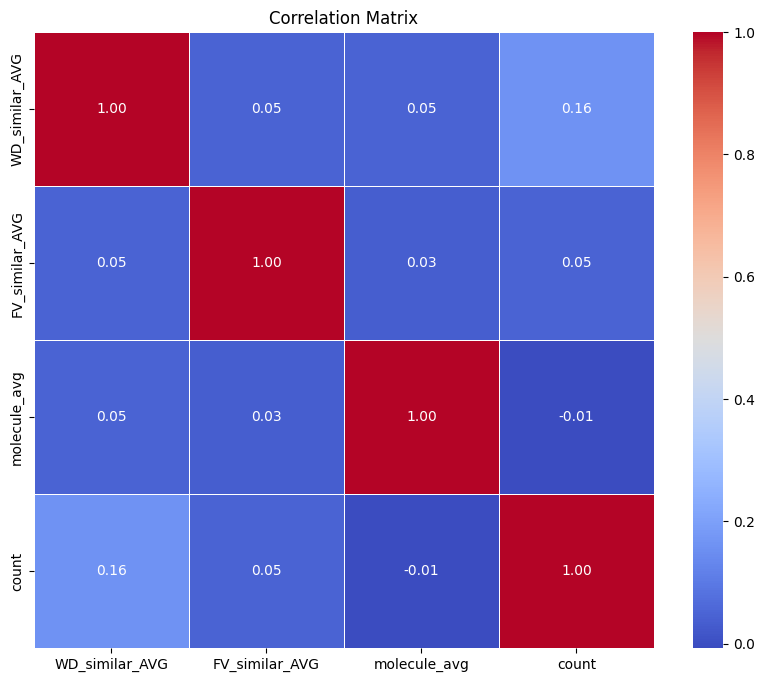

In [ ]:
# ヒートマップをプロット
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

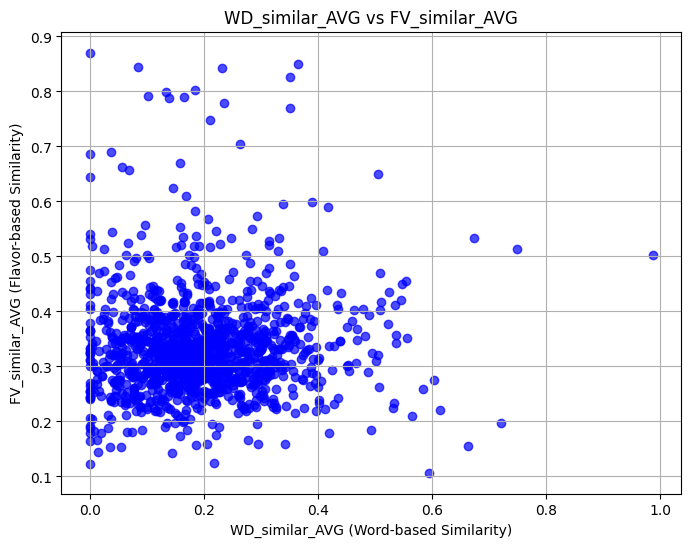

In [ ]:
# 相関の可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_result["WD_similar_AVG"], df_result["FV_similar_AVG"], alpha=0.7, color="blue")
plt.title("WD_similar_AVG vs FV_similar_AVG")
plt.xlabel("WD_similar_AVG (Word-based Similarity)")
plt.ylabel("FV_similar_AVG (Flavor-based Similarity)")
plt.grid(True)
plt.show()

In [13]:
# 似てないやつ
# 差を計算して新しい列を作成
df_result["difference"] = abs(df_result["WD_similar_AVG"] - df_result["FV_similar_AVG"])

# 差が大きい順に並べ替え
sorted_df = df_result.sort_values(by="difference", ascending=False)

# 上位の行を確認
sorted_df.head()
sorted_df[["name", "WD_similar_AVG", "FV_similar_AVG"]].to_csv("../tmp/analized_recipe.csv")

In [14]:
df_result[df_result["FV_similar_AVG"] < 0.2][["name", "WD_similar_AVG", "FV_similar_AVG"]].sort_values(by="FV_similar_AVG", ascending=True)

,name,WD_similar_AVG,FV_similar_AVG
621,Homemade Flour Tortillas,0.594403,0.106865
152,How to Make Homemade Butter Recipe,0.000000,0.122424
641,Homemade Peanut Butter,0.217359,0.124528
850,Spargel in Schinken (White Asparagus Wrapped i...,0.144573,0.141846
649,Oysters on the Half Shell,0.014662,0.143856
490,How to Make Wonton Wrappers,0.055586,0.153289
146,How to Cook Quinoa,0.035456,0.153639
173,Southern Lima Beans (Butter Beans),0.662867,0.155198
705,Te de Canela (Cinnamon Tea),0.185701,0.157341
632,Hopi Blue Corn Tortillas,0.342458,0.158080


In [ ]:
df_result[0.6 < df_result["FV_similar_AVG"]][["name", "WD_similar_AVG", "FV_similar_AVG"]].sort_values(by="FV_similar_AVG", ascending=True)

,name,FV_similar,FV_similar_AVG
1124,Modern Watergate Salad,"{(0, 1): 0.8556823770115498, (0, 2): 0.6400732...",0.610399
422,Homemade Almond Butter,"{(0, 1): 0.5453521042270344, (0, 2): 0.6985849...",0.624319
637,Homemade Hot Chocolate Mix,"{(0, 1): 0.6352029987300478, (0, 2): 0.8625577...",0.644586
1113,Caramel Apple Cheesecake Dip,"{(0, 1): 0.23650308980111137, (0, 2): 0.658013...",0.650180
570,Manhattan,"{(0, 1): 0.7367445852715735, (0, 2): 0.5623442...",0.656511
813,German Semolina Pudding,"{(0, 1): 0.8625577707211173, (0, 2): 0.5571776...",0.661744
567,Paneer Butter Masala Recipe,"{(0, 1): 0.482081700079791, (0, 2): 0.49119568...",0.668803
800,Cioccolata Calda (Hot Chocolate Italian-Style),"{(0, 1): 0.6101803664673096, (0, 2): 0.8625577...",0.685191
203,Mocha Coffee,"{(0, 1): 0.7471010094061539, (0, 2): 0.7762121...",0.690134
406,Best Meatball Recipe,"{(0, 1): 0.7991678800964521, (0, 2): 0.7574436...",0.704790


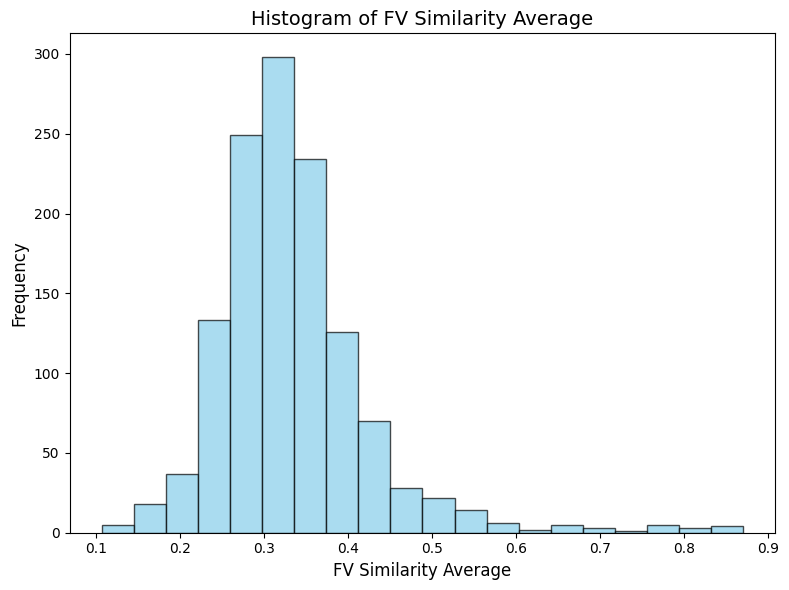

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df_result["FV_similar_AVG"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of FV Similarity Average", fontsize=14)
plt.xlabel("FV Similarity Average", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

## Word2Vec可視化

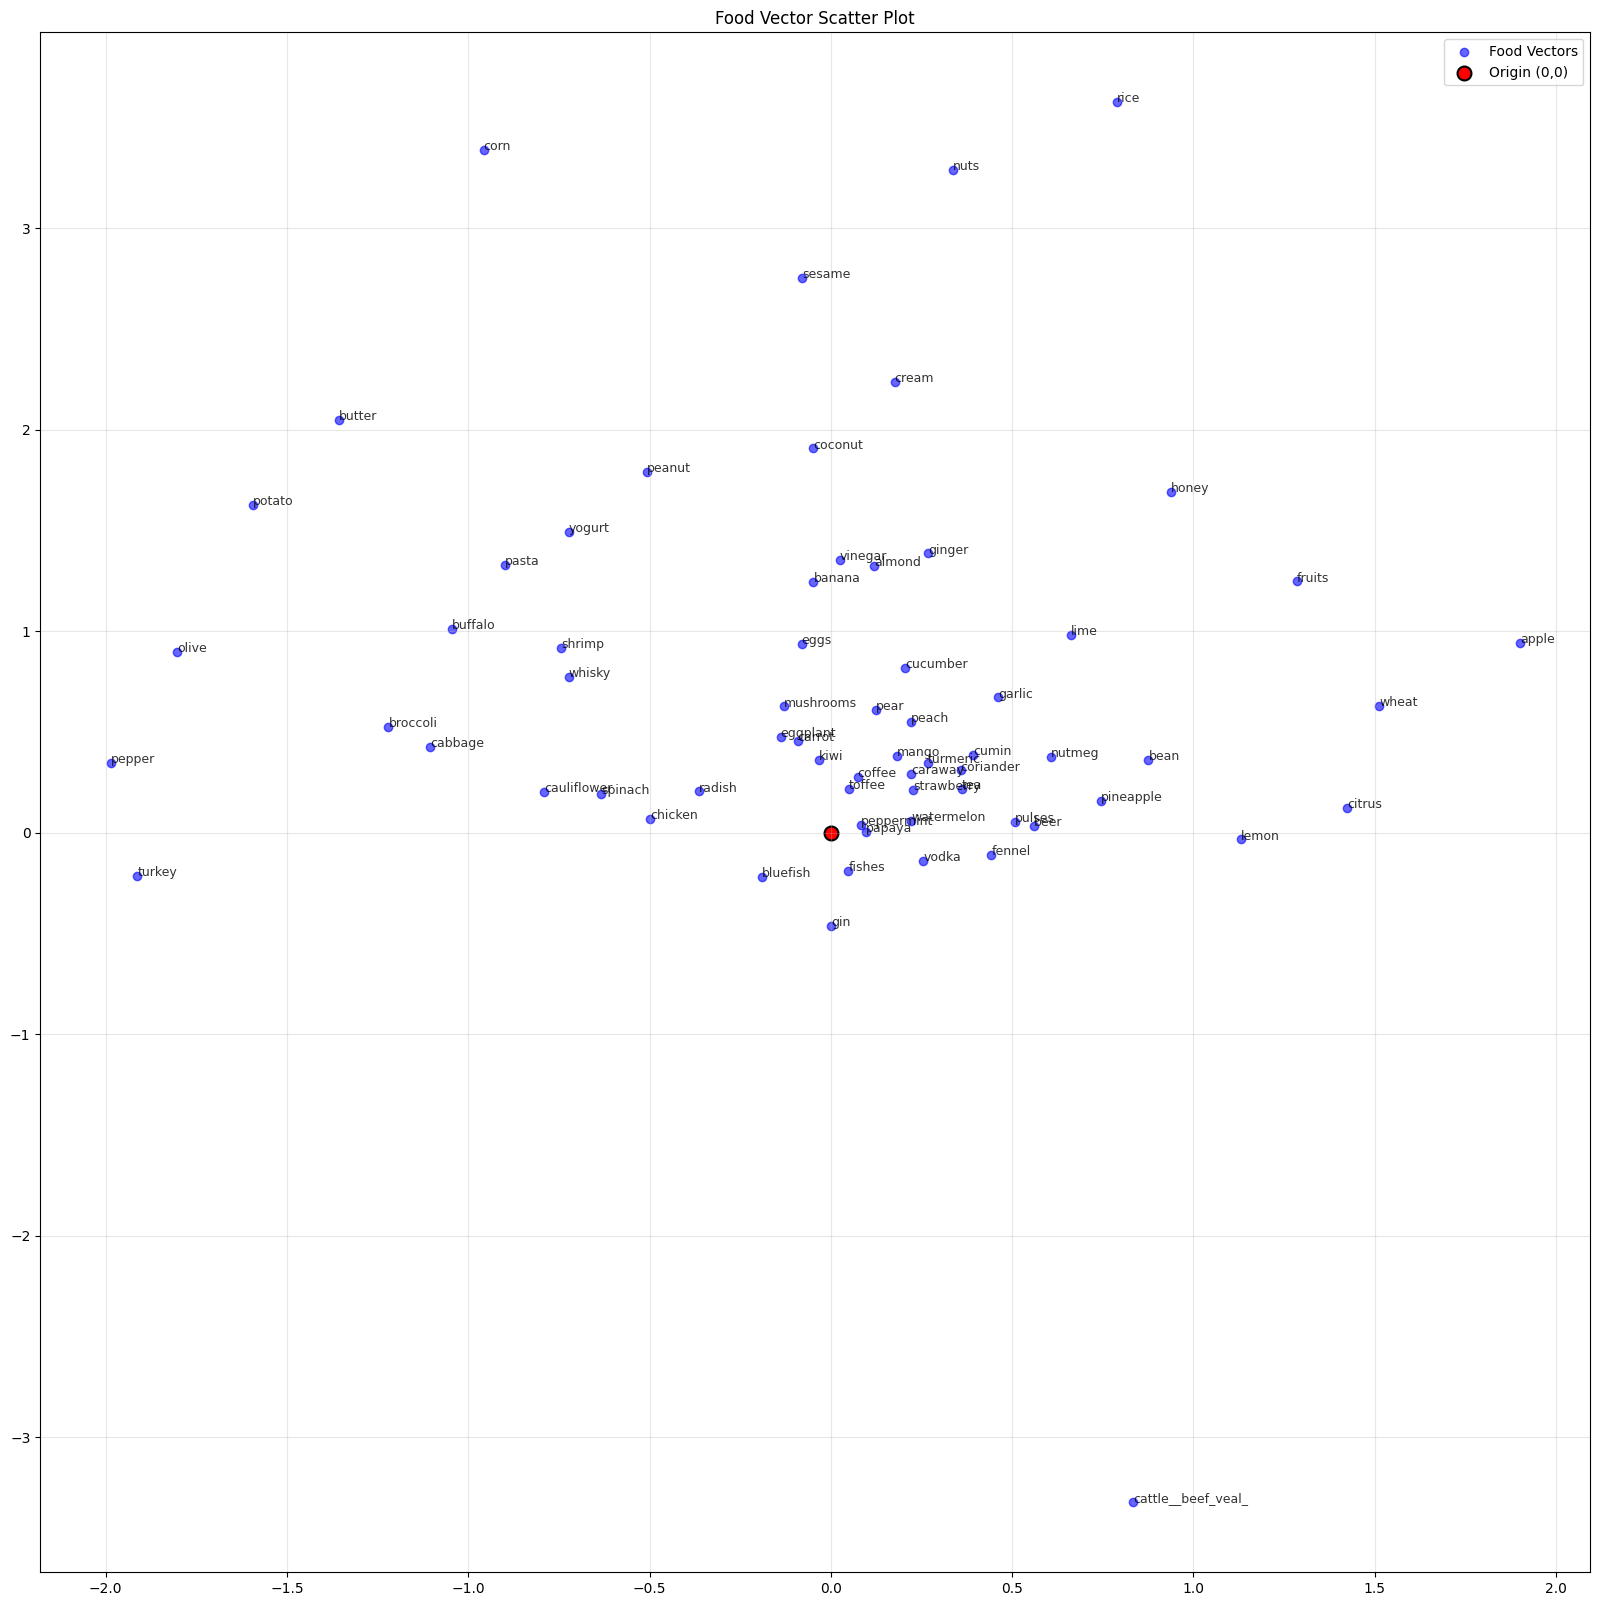

In [ ]:
show_items = ['kiwi','garlic','pineapple','peanut','cattle__beef_veal_','chicken','cauliflower','broccoli',
'tea','pepper','papaya','caraway','watermelon','lime','lemon','coffee','coriander','cucumber',
'cumin','turmeric','fennel','strawberry','apple','mango','peppermint','nutmeg','olive','rice',
'almond','peach','pear','radish','sesame','eggplant','potato','spinach','corn','ginger','banana',
'carrot','beer','pasta','bluefish','buffalo','coconut','turkey','shrimp','wheat','eggs','yogurt',
'bean','vodka','whisky','gin','honey','vinegar','toffee','butter','cream','cabbage','mushrooms',
'citrus','fishes','pulses','nuts','fruits']

def find_food(tx):
    # クエリ実行と結果の取得
    return tx.run("MATCH (f:Food) RETURN f").data()

vectors = []
labels = []

with driver.session() as session:
    # クエリ結果をループ処理
    foods = session.execute_read(find_food)
    for i, record in enumerate(foods):
        vec = np.array(record["f"]["word_vector"])
        if record["f"]["id"] in show_items:
            vectors.append(vec)            
            labels.append((vec[:2], record["f"]["id"]))
            
vectors = np.array(vectors)
# 散布図をプロット
plt.figure(figsize=(20, 20))
plt.scatter(vectors[:, 0], vectors[:, 1], alpha=0.6, c="blue", label="Food Vectors")

# ラベルをプロット（10個に1つだけ）
for (x, y), label in labels:
    plt.text(x, y, label, fontsize=9, alpha=0.8)
    
plt.scatter(0, 0, c="red", s=100, label="Origin (0,0)", edgecolors="black", linewidth=1.5)
plt.title("Food Vector Scatter Plot")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### similarityの可視化

In [ ]:
def project_similarity_graph(tx):
    tx.run("""
        CALL gds.graph.list() 
        YIELD graphName WITH graphName 
        WHERE graphName = 'kmeansGraph' 
        CALL gds.graph.drop('kmeansGraph') 
        YIELD graphName AS droppedGraph RETURN droppedGraph;
    """)
    tx.run("""
        CALL gds.graph.project(
            'kmeansGraph',
            {
                Food: {
                    properties: ['word_vector', 'flavor_vector']
                }
            },
            {
                CONTAINS: {
                    orientation: 'UNDIRECTED'
                }
            }
        );
     """)
    
def fetch_pagerank_and_edges():
    # Word2Vecのクラスタリングを取得
    word_query = """
        CALL gds.kmeans.stream('kmeansGraph', {
            nodeLabels: ['Food'],
            relationshipTypes: ['CONTAINS'],
            k: 100, // クラスタの数を指定
            maxIterations: 100, // 最大反復回数
            nodeProperty: 'word_vector' // クラスタリングに使用するプロパティ
        })
        YIELD nodeId, communityId, distanceFromCentroid, silhouette
        WITH gds.util.asNode(nodeId) AS node, communityId, distanceFromCentroid, silhouette
        RETURN node.id as id, node.name AS name, communityId, distanceFromCentroid, silhouette
        ORDER BY communityId, distanceFromCentroid;
    """
    
    # Flavorのクラスタリングを取得
    flavor_query = """
        CALL gds.kmeans.stream('kmeansGraph', {
            nodeLabels: ['Food'],
            relationshipTypes: ['CONTAINS'],
            k: 100, // クラスタの数を指定
            maxIterations: 100, // 最大反復回数
            nodeProperty: 'flavor_vector' // クラスタリングに使用するプロパティ
        })
        YIELD nodeId, communityId, distanceFromCentroid, silhouette
        WITH gds.util.asNode(nodeId) AS node, communityId, distanceFromCentroid, silhouette
        RETURN node.id as id, node.name AS name, node.display_name_ja as display_name_ja, communityId, distanceFromCentroid, silhouette
        ORDER BY communityId, distanceFromCentroid;
    """
    
    with driver.session() as session:
        session.write_transaction(project_similarity_graph)
        word_result = session.run(word_query)
        flavor_result = session.run(flavor_query)
        
        word_df = pd.DataFrame([dict(record) for record in word_result])
        flavor_df = pd.DataFrame([dict(record) for record in flavor_result])
        
    return word_df, flavor_df

# データ取得
word_df, flavor_df = fetch_pagerank_and_edges()


/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_77549/1744557776.py:57: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(project_similarity_graph)


In [19]:
word_df.tail(3)
word_df.to_csv('../tmp/word_df.csv')

In [20]:
flavor_df.tail(3)
flavor_df.to_csv('../tmp/flavor_df.csv')

In [21]:
# wordでもflavorでも同じコミュニティに属している組み合わせのidをリストに追加する
tt_list = []

# word_dfを1件づつ検査する
for i, row in word_df.iterrows():
    same_list = []
    food_id = row['id']
    community_id = row['communityId']
    same_community_ids = (flavor_df[flavor_df['communityId'] == community_id])['id'].values
    flavor_row = flavor_df[flavor_df['id'] == food_id]
    
    # 取得したcommunityIdと同じcommunityIdの行をflavor_dfから抽出する
    community_rows = flavor_df[flavor_df['communityId'] == flavor_row["communityId"].values[0]]
    
    for j, f_row in community_rows.iterrows():
        if f_row['id'] in same_community_ids:
            same_list.append((f"{f_row['id']}: {f_row['display_name_ja']}"))
            
    if same_list is not None and len(same_list) > 0:
        tt_list.append(same_list)

matched = pd.DataFrame(tt_list)
matched.transpose()
matched.transpose().to_csv('../tmp/matched.csv')

## 因果分析